In [97]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os, sys
from pathlib import Path
from tqdm import tqdm
from collections import defaultdict, Counter
import pickle
import pdb
import datetime
from glob import glob
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Image as IImage


def show_dct(dct, n=3):
    return dict(list(dct.items())[:n])


pdata = Path('/data/utkface/')
p = Path('.')
from fastai import *
from fastai.vision import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
df = pd.read_csv('img2targets.csv')

In [99]:
class MultitaskDataset(Dataset):
    "`Dataset` for joint single and multi-label image classification."
    def __init__(self, 
                 fns,
                 labels_gender,
                 labels_race,
                 ages,
                 classes_race,
                 classes_gender):
        self.x = np.array(fns)
        
        self.classes_gender = classes_gender
        self.classes_race = classes_race

        self.class2idx_gender = {v:k for k,v in enumerate(self.classes_gender)}
        self.y_gender = np.array([self.class2idx_gender[o] for o in labels_gender], dtype=np.int64)

        self.class2idx_race = {v:k for k,v in enumerate(self.classes_race)}
        self.y_race = np.array([self.class2idx_race[o] for o in labels_race], dtype=np.int64)
        
        self.y_age = ages[:, None].astype('float32')
        
        self.c_gender = len(classes_gender)
        self.c_race = len(classes_race)
        self.c_age = 1

        self.c = self.c_gender + self.c_race + self.c_age

    
    def __len__(self): return len(self.x)
    
    def __getitem__(self,i:int)->Tuple[Image, np.ndarray, np.ndarray]: 
        return open_image(self.x[i]), torch.tensor([self.y_gender[i], self.y_race[i], self.y_age[i]]).float()
    
    def __repr__(self): return f'{type(self).__name__} of len {len(self)}'

In [100]:
def get_dataset(df):
    return MultitaskDataset(df.img_name, 
                            labels_gender=df.gender, 
                            labels_race=df.race,
                            ages=df.age,
                            classes_race=sorted(set(df.race)),
                            classes_gender=sorted(set(df.gender))
                           )

In [101]:
train_ds = get_dataset(df[df.is_train==1])
valid_ds = get_dataset(df[df.is_train==0])

In [102]:
def get_data(sz, bs):
    return ImageDataBunch.create(train_ds, valid_ds, path=p, bs=bs, size=sz,
                            ds_tfms=get_transforms()).normalize(imagenet_stats)

In [103]:
data = get_data(sz=200, bs=8)

In [104]:
data.valid_ds[np.random.choice(len(data.valid_ds))]

(Image (3, 200, 200), tensor([  0.,   4., 100.]))

In [105]:
(igender, irace, age)

(tensor(1.), tensor(1.), tensor(28.))

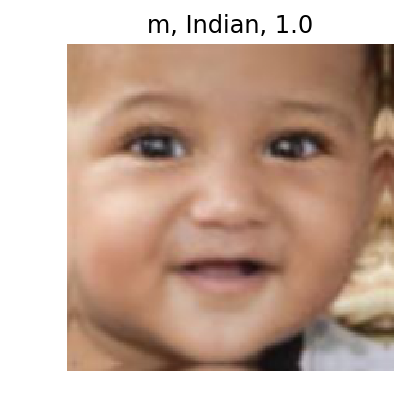

In [106]:
img, (igender, irace, age) = data.valid_ds[np.random.choice(len(data.valid_ds))]
gender = data.valid_ds.classes_gender[int(igender)]
race = data.valid_ds.classes_race[int(irace)]
img.show(title= f"{gender}, {race}, {age}")

## model

In [107]:
def multitask_loss(input, target):
    input_gender = input[:,:data.c_gender]
    input_race = input[:,data.c_gender:data.c_gender+data.c_race]
    input_age = input[:,-data.c_age:]
    target_gender, target_race, target_age = target[:,0], target[:, 1], target[:, 2]
    loss_gender = F.cross_entropy(input_gender, target_gender.long())
    loss_race = F.cross_entropy(input_race, target_race.long())
    loss_age = F.l1_loss(input_age, target_age.unsqueeze(1))
    return loss_gender/(.16) + loss_race/(.44) +  loss_age/10

def accuracy_gender(input, targs):
    input_gender = input[:,:data.c_gender]
    target_gender = targs[:, 0].long()
    return accuracy(input_gender, target_gender)

def accuracy_race(input, targs):
    input_race = input[:,data.c_gender:data.c_gender+data.c_race]
    target_race = targs[:, 1].long()
    return accuracy(input_race, target_race)

def l1loss_age(input, targs):
    input_age = input[:,-data.c_age:]
    target_age = targs[:, 2].unsqueeze(1)
    return F.l1_loss(input_age, target_age).mean()


learn = create_cnn(data, models.resnet50, 
                    metrics=[accuracy_gender,
                            accuracy_race,
                            l1loss_age],
                    loss_func=multitask_loss)

def train_size(sz, bs, lr):
    learn.data=get_data(sz, bs)
    learn.freeze()
    learn.fit_one_cycle(5, slice(lr))
    learn.unfreeze()
    learn.fit_one_cycle(5, slice(lr/20, lr/2), pct_start=0.1)
    learn.save(f"multitask-{sz}")

sz, bs = 200, 8 

learn.data=get_data(sz, bs)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


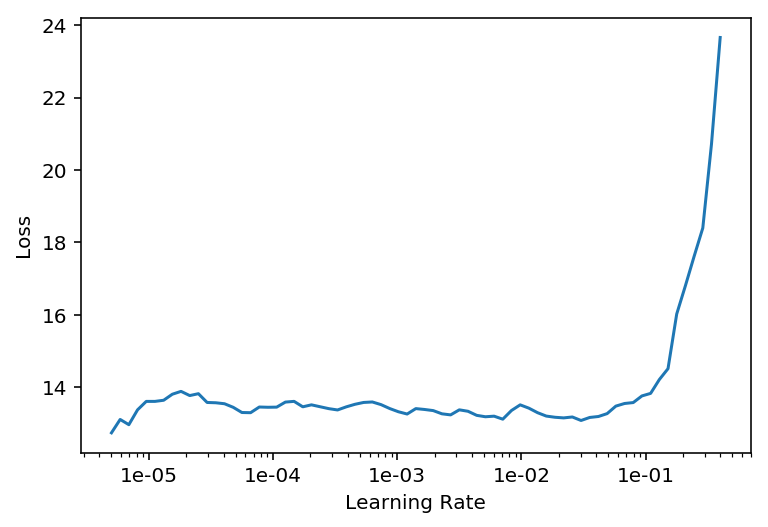

In [108]:
learn.lr_find(start_lr=1e-6)
learn.recorder.plot()

In [109]:
lr=1e-3

train_size(sz, bs, lr)

Total time: 12:00
epoch  train_loss  valid_loss  accuracy_gender  accuracy_race  l1loss_age
1      4.700834    3.661277    0.916314         0.768385       7.424756    (02:24)
2      4.095838    3.258113    0.930473         0.793533       7.279992    (02:22)
3      3.831204    2.779254    0.939560         0.836221       6.388206    (02:22)
4      3.419484    2.533519    0.943787         0.851648       5.906605    (02:25)
5      3.339583    2.491439    0.944632         0.854184       5.857907    (02:25)

